In [177]:
import pyspark
from   pyspark.sql import SparkSession
from   pyspark.sql.functions import to_date, date_format
import pyspark.sql.functions as F
from   matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions
%matplotlib inline

In [178]:
DB_HOST = 'challenge.prod.public.data.escale.com.br'
DB_NAME = 'challenge'
DB_PORT = '5432'
DB_USER = 'challenge'
DB_PASS = 'Escale@2020'
SPARK_APP = 'Case Escale'

In [179]:
spark = SparkSession \
        .builder \
        .appName(SPARK_APP) \
        .config("spark.jars", "/path_to_postgresDriver/postgresql-postgresql-42.2.19.jre7.jar") \
        .getOrCreate()

In [180]:
# Funcao que recebe as variaveis contendo o host e credenciais para acessar a base de dados

def tableReader(tableName):
  global DB_HOST
  global DB_NAME
  global DB_PORT
  global DB_USER
  global DB_PASS
  tempDf = spark.read \
            .format("jdbc") \
            .option("url", f"jdbc:postgresql://{DB_HOST}:{DB_PORT}/{DB_NAME}") \
            .option("dbtable", tableName) \
            .option("user", DB_USER) \
            .option("password", DB_PASS) \
            .option("driver", "org.postgresql.Driver") \
            .load()
  return tempDf

In [181]:

def executeQuery(query):
    tempDf = spark.sql(query)
    return tempDf.toPandas()

In [182]:
##
attendacesDf = tableReader("attendances")
attendancesCallsDf = tableReader("attendances_calls")

In [183]:
# Relacionamento entre as tabelas Attendances e Attendances_call

newAttendacesDf = attendancesCallsDf.join(attendacesDf, attendancesCallsDf.attendance_id == attendacesDf.id, how="inner")

In [184]:
# Criacao do Dataframe newAttendacesDf contendo apenas as colunas necessarias para elaboracao dos kpis

newAttendacesDf = newAttendacesDf.select(F.col("attendance_id"),
                                         F.col("token").alias("token_key"),
                                         F.col("main_connection"),
                                         F.when(F.col("type_id") == 1, "Venda").otherwise("Não Venda").alias("record_type"),
                                         F.col("monthly_value").alias("monthly_amount")) \
                                  .dropDuplicates()

newAttendacesDf = newAttendacesDf.withColumn("attendance_key", F.monotonically_increasing_id())

newAttendacesDf.createOrReplaceTempView("dim_attendance")

In [185]:
##
lineMKTFinalDf = tableReader("lines_mkt_final")

In [186]:
newlineMKTFinalDf = lineMKTFinalDf.select(F.col("id").alias("line_key"),
                                          F.col("line_id"),
                                          F.col("midia"),
                                          F.col("campanha").alias("campaign"),
                                          F.col("fonte").alias("source"),
                                          F.col("pagina").alias("web_page"))\
                                   .dropDuplicates()
newlineMKTFinalDf.createOrReplaceTempView("dim_line_mkt")

In [187]:
calendarDf = spark.sql("SELECT sequence(to_date('2020-01-01'), to_date('2020-12-31'), interval 1 day) as date")
calendarDf = calendarDf.withColumn("date", F.explode(F.col("date")))
calendarDf = calendarDf.withColumn("day", F.dayofmonth("date"))
calendarDf = calendarDf.withColumn("month", F.month("date"))
calendarDf = calendarDf.withColumn("year", F.year("date"))
calendarDf = calendarDf.withColumn("quarter", F.quarter("date"))



In [188]:
#callHistoryQueueDf = callHistoryQueueDf.join(newCalendarDf, newCalendarDf.date == callHistoryQueueDf.created_at, how="inner")

newCalendarDf = calendarDf.select(F.col("date"),
                                     F.col("day"),
                                     F.col("month"),
                                     F.col("quarter"),
                                     F.col("year"))\
                                     .dropDuplicates()

newCalendarDf.createOrReplaceTempView("dim_calendar")         

In [189]:
callHistoryQueueDf = tableReader("call_history_queue")
telephonyTypeDf = tableReader("telephony_types")

In [190]:
telephonyTypeDf = telephonyTypeDf.selectExpr("id as phone_id", "description as phone_description")\
                                 .dropDuplicates()

callHistoryQueueDf = callHistoryQueueDf.join(telephonyTypeDf.selectExpr("phone_id", "phone_description as modality"),
                                             callHistoryQueueDf.queue_log_modality_types_id == telephonyTypeDf.phone_id,
                                             how="left")

callHistoryQueueDf = callHistoryQueueDf.join(telephonyTypeDf.selectExpr("phone_id  as verb_types_id", "phone_description as call_status"),
                                             callHistoryQueueDf.queue_log_verb_types_id == telephonyTypeDf.phone_id,
                                             how="left")

callHistoryQueueDf = callHistoryQueueDf.join(telephonyTypeDf.selectExpr("phone_id as line_type_id", "phone_description as call_group"),
                                             callHistoryQueueDf.queue_log_line_types_id == telephonyTypeDf.phone_id,
                                             how="left")

newCallHistoryQueueDf = callHistoryQueueDf.select(F.col("id").alias("call_key"),
                                                  F.col("id").alias("call_id"),
                                                  F.col("token").alias("token_key"),
                                                  F.col("lines_id").alias("line_id"),
                                                  F.col("modality"),
                                                  F.col("call_status"),
                                                  F.col("call_group"),
                                                  F.col("uf"),
                                                  F.col("duration"),
                                                  F.col("agent"),
                                                  F.to_date("created_at", "yyyy-MM-dd").alias("created_at"))\
                                          .dropDuplicates()

newCallHistoryQueueDf.createOrReplaceTempView("fact_call")

In [15]:
query01 ="""
select date(dlr.date) as created_at,
       count(distinct fc.call_id) as call_id
from fact_call fc
        left join 
            dim_calendar dlr
on   dlr.date = fc.created_at        
group by
     dlr.date    
order by
      created_at
"""

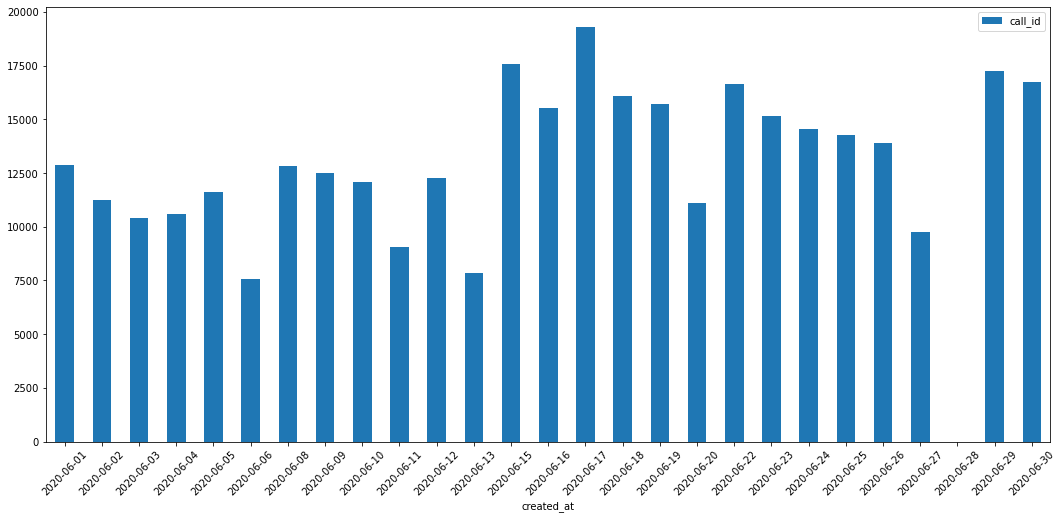

In [17]:
question01Df = executeQuery(query01)
question01Df.plot.bar(x='created_at', y='call_id', rot=0)
plt.rcParams['figure.figsize'] = (18,8)
plt.xticks(rotation=45)
plt.show()

In [193]:
query02 ="""
select  dl.midia,
        sum(coalesce(da.monthly_amount,0)) as monthly_amount,
        count(distinct fc.call_id) as call
from    fact_call fc
left join
        dim_attendance da
on      da.token_key = fc.token_key
left join
        dim_line_mkt dl
on      dl.line_id = fc.line_id
where  da.record_type = 'Venda'
and    dl.midia is not null
group by
        dl.midia
"""

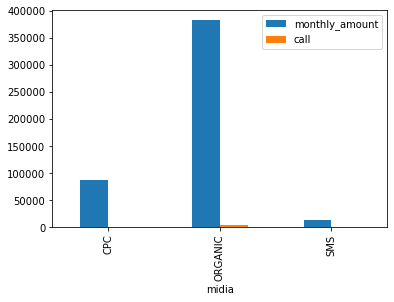

In [194]:
question02Df = executeQuery(query02)
question02Df.plot(x="midia", y=["monthly_amount", "call"], kind="bar")
plt.rcParams['figure.figsize'] = (18,8)

In [50]:
query03A="""
select dm.midia
      ,count(distinct fc.call_id) as call 
from dim_line_mkt dm
left join 
         fact_call fc
on    dm.line_id = fc.line_id         
where   fc.modality = 'Entrada'
group by
        dm.midia
"""

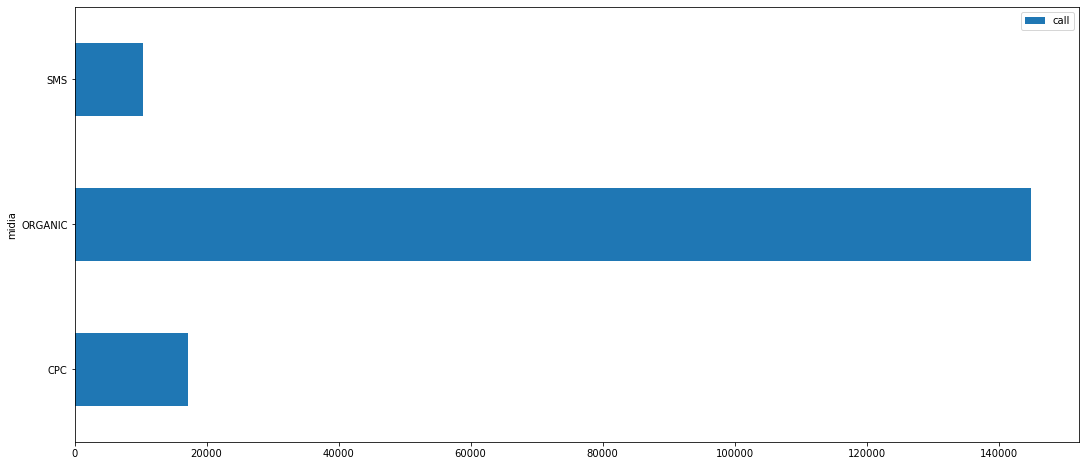

In [30]:
question03ADf = executeQuery(query03A)
question03ADf.plot(x="midia", y=["call"], kind="barh")
plt.rcParams['figure.figsize'] = (10,10)

In [68]:
query03B ="""
select 
        dm.campaign
       ,count(distinct fc.call_key) as call_id 
from dim_line_mkt dm
left join
        fact_call   fc
on    dm.line_id  = fc.line_id    
where fc.modality ='Entrada'
group by 
       dm.campaign
order by 
       call_id asc
limit 20       
"""

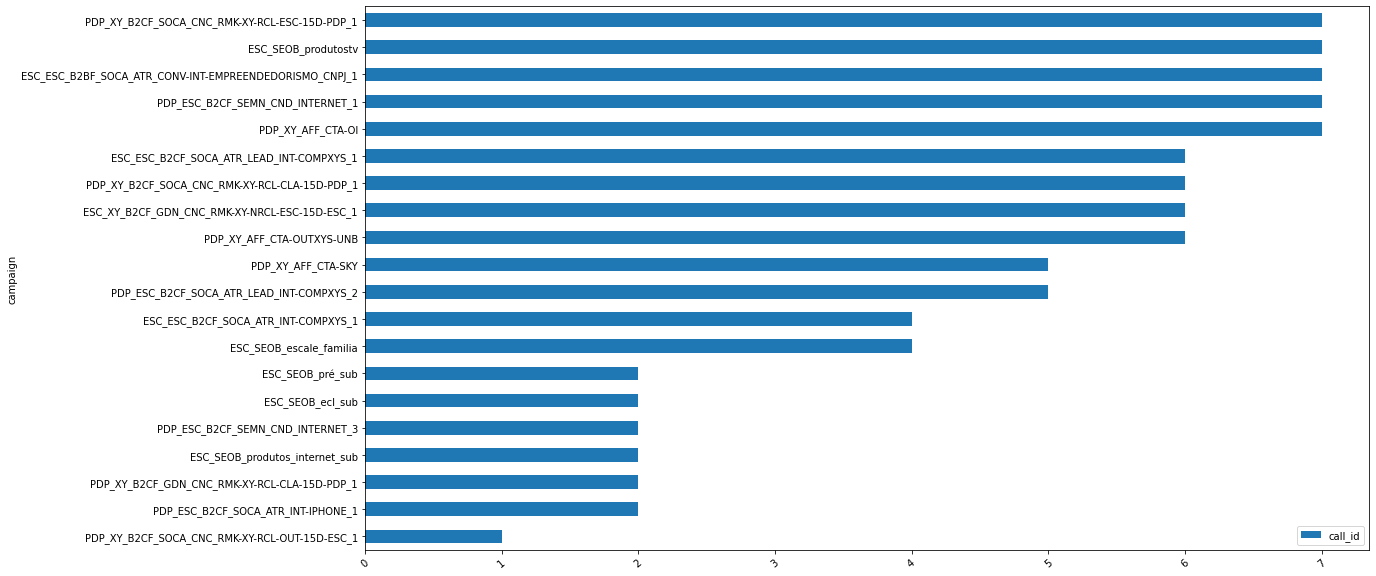

In [69]:
question03BDf = executeQuery(query03B)
question03BDf.plot(x="campaign", y=["call_id"], kind="barh")
plt.xticks(rotation=40)
plt.rcParams['figure.figsize'] = (18,10)
plt.show()

In [72]:
query04="""
select  fc.modality
        ,da.record_type
        ,coalesce(da.monthly_amount,0) as monthly_amount       
from fact_call fc
left join
     dim_attendance da
on  fc.token_key = da.token_key  
where  da.record_type = 'Venda'
"""

<AxesSubplot:xlabel='modality', ylabel='monthly_amount'>

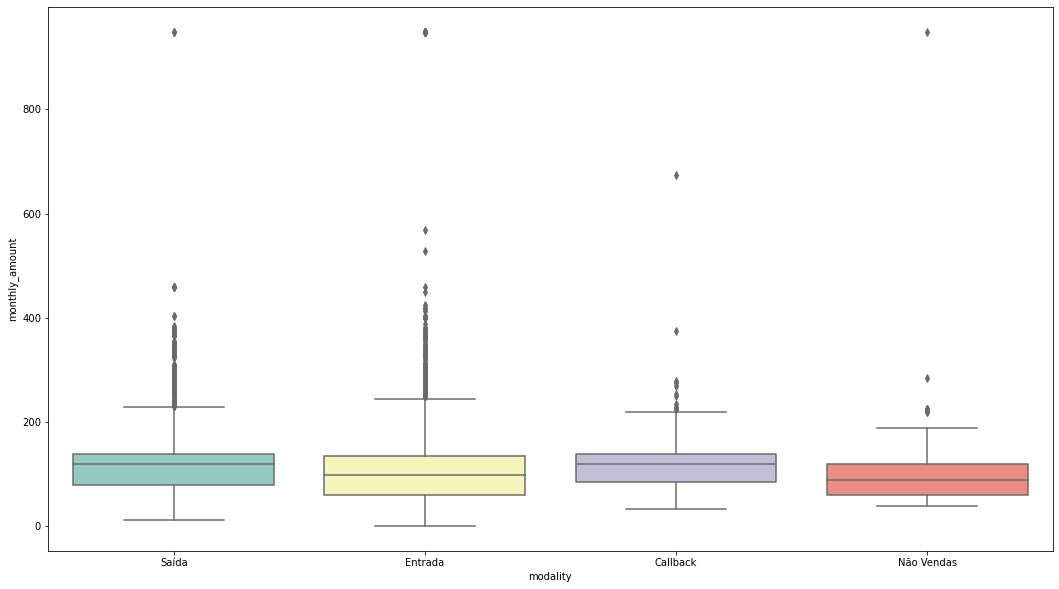

In [73]:
question04Df = executeQuery(query04)
sns.boxplot(x="modality", y="monthly_amount", data=question04Df, palette="Set3")

In [86]:
query05="""
select fc.uf,
       sum(coalesce(da.monthly_amount, 0)) as monthly_amount
from fact_call fc 
left join
       dim_attendance da
on     fc.token_key = da.token_key  
where da.record_type ='Venda'
group by
        fc.uf
order by 
        monthly_amount asc      
     
       
"""

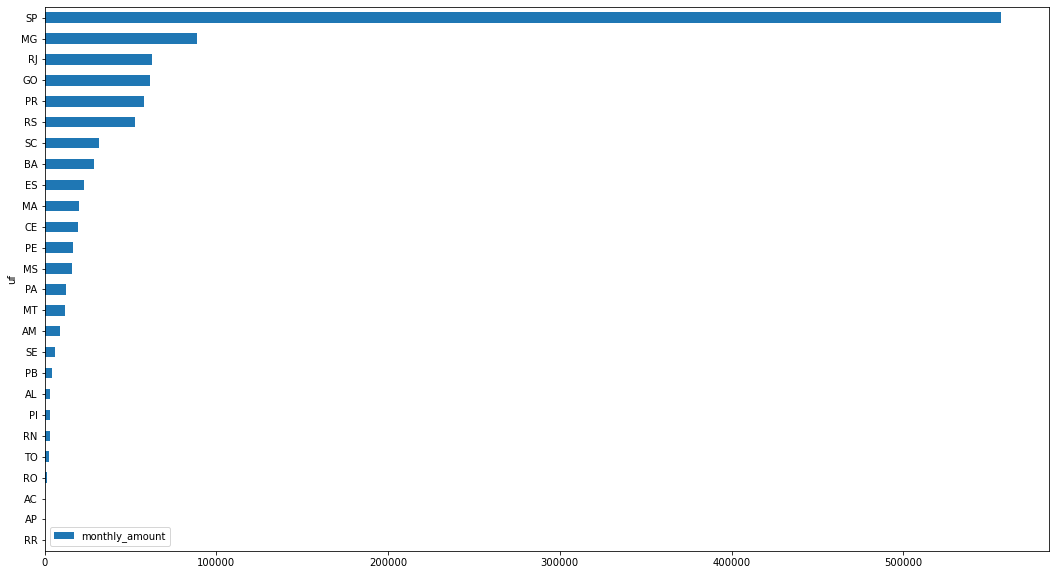

In [87]:
question05Df = executeQuery(query05)
question05Df.plot(x="uf", y="monthly_amount", kind="barh")
plt.rcParams['figure.figsize'] = (18,10)